Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Data loaded from /scratchx/mcarenso/tempest/ARPEGE_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/IFS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/MPAS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SCREAMv1_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SAM_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/UM_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/XSHiELD_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/GEOS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/GRIST_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scr

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Data loaded from /scratchx/mcarenso/tempest/ARPEGE_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/IFS_Summ

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Data loaded from /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/code/tempest/tempest/joint_distrib.py:464: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


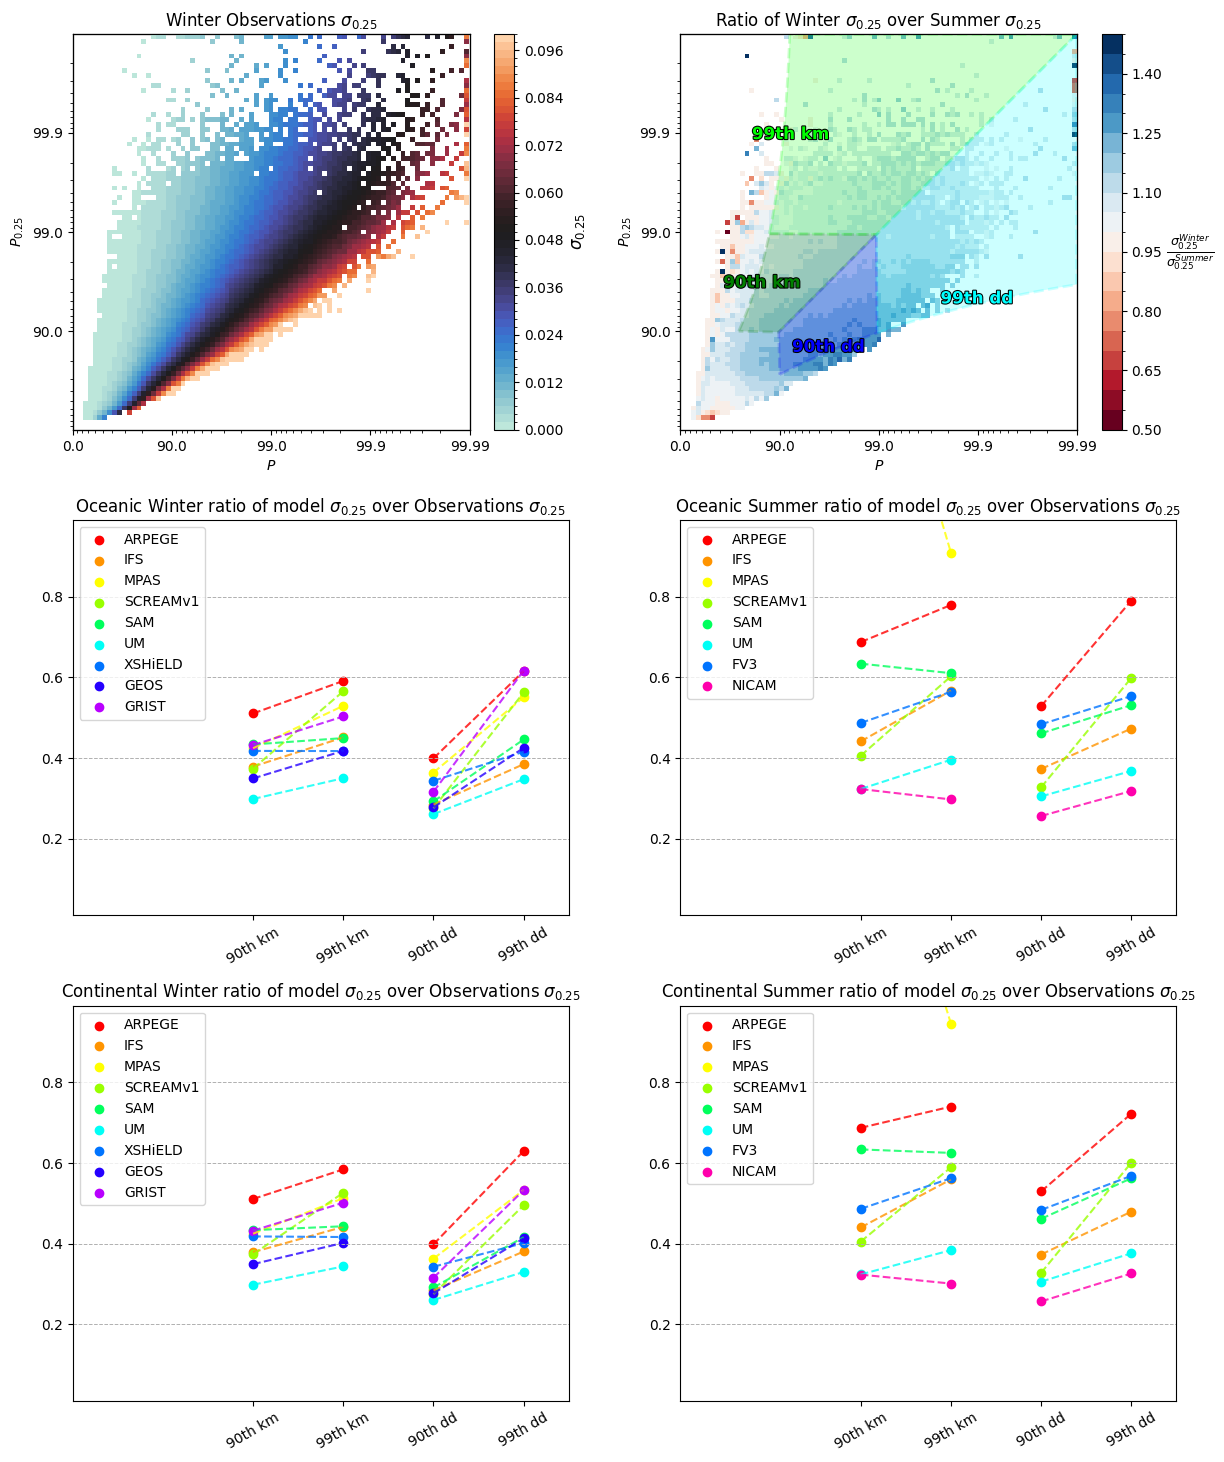

In [44]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import matplotlib.patheffects as path_effects
from matplotlib.patches import Polygon as MplPolygon


import pandas as pd
import xarray as xr
import seaborn as sns
import warnings
import logging
from skimage import measure # pylance: disable=import-error 

from scipy.optimize import minimize
import plotly.graph_objects as go
from shapely.geometry import LineString

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

alpha = "75" #compare to article this is 100(1-alpha) 
nbpd = 20 # maybe trying with 40 once the legends are added
nd = 4
same_rank_bool = True # if False then the jdist ranks are computed for ocean and land, rather than for both

fig_path = f"/scratchx/mcarenso/tempest/figures/sigma_ratios_nd_{nd}_nbpd_{nbpd}_alpha_{alpha}_same_rank_{str(same_rank_bool)}.png"


def find_plot_contour(self, ax_show , N_branch=80, offset_low = 1, offset_up=1, color = 'k', lstyle = '--', model_name = None):
    Z = self.norm_density.T
    # -- Branches
    Z_contour = np.copy(Z)
    # Z_contour[18:, 18:] = 1 ## this number actually depends on nd and nbpd and the general shape of the Y 
    cont = measure.find_contours(Z_contour, 1)
    N = N_branch
    # fit
    popt_1, x_1, y_1, popt_2, x_2, y_2, func = self._fit_branches(cont,N, offset_low, offset_up)
    x_branch_2 = y_branch_1 = np.linspace(5,N_branch,N_branch)
    y_branch_2 = func(x_branch_2,*popt_2)
    x_branch_1 = func(y_branch_1,*popt_1)

    # Create line strings for intersection
    curve1 = LineString(np.column_stack((x_branch_1, y_branch_1)))
    curve2 = LineString(np.column_stack((x_branch_2, y_branch_2)))
    
    if ax_show is not False : 
        # show branches
        ax_show.plot(x_branch_1,y_branch_1, color = color, linestyle = lstyle, linewidth = 3, alpha = 0.5)
        ax_show.plot(x_branch_2,y_branch_2, color = color, linestyle = lstyle, linewidth = 3, alpha = 0.5, label  = model_name)

    return ax_show, curve1, curve2

def plot_kite(jd, fig=None, ax=None):
    if fig is None : 
        fig, ax = plt.subplots(1, 1)
    # Plot the initial polygons

    _, curve1, curve2 = find_plot_contour(jd, ax_show = False, N_branch=81, offset_low = 1, offset_up=1, color = 'k', lstyle="--", model_name = model_name+" Summer")

    curve1_coords = np.array(curve1.coords)

    km90_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,1]-20))
    last_index = np.argmin(np.abs(curve1_coords[:,1]-40))
    km90_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    km90_vertices.append((40, 40))  
    km90_vertices.append((20, 20))  

    km99_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,1]-40))
    last_index = np.argmin(np.abs(curve1_coords[:,1]-81))
    km99_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    km99_vertices.append((81, 81))  
    km99_vertices.append((40, 40))  

    curve1_coords = np.array(curve2.coords)

    dd90_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,0]-20))
    last_index = np.argmin(np.abs(curve1_coords[:,0]-40))
    dd90_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    dd90_vertices.append((40, 40))  
    dd90_vertices.append((20, 20))  

    dd99_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,0]-40))
    last_index = np.argmin(np.abs(curve1_coords[:,0]-81))
    dd99_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    dd99_vertices.append((81, 81))  
    dd99_vertices.append((40, 40))  

    polygons = [
        (km90_vertices, 'green', '90th km'),
        (km99_vertices, 'lime', '99th km'),
        (dd99_vertices, 'cyan', '99th dd'),
        (dd90_vertices, 'blue', '90th dd')
    ]

    # Create a new patch with the constructed vertices
    for vertices, color, label in polygons:
        polygon = MplPolygon(vertices, closed=True, edgecolor=color, facecolor=color, linewidth=2, linestyle='--', alpha=0.2)
        ax.add_patch(polygon)
        
        # Calculate approximate center for text placement
        x_coords, y_coords = zip(*vertices)
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)
        
        # Add text annotation
        text = ax.text(center_x, center_y, label, color=color, fontsize=12, ha='center', va='center', weight='bold')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])
    
    return None

def apply_mask(data, mask, mask_compat):
    shape = np.shape(data)
    mask = mask_compat & mask  # join mask
    
    fdata, fmask = data.reshape(-1), mask.reshape(-1)
    fdata[~fmask] = np.nan
    rdata = fdata.reshape(shape)
    return rdata


# Objective function to minimize
def objective(coeff, data, data2):
    # Reshape to 1D and remove NaNs
    data_flat = data.reshape(-1)
    data2_flat = data2.reshape(-1)

    # Remove NaNs
    valid_indices = ~np.isnan(data_flat) & ~np.isnan(data2_flat)
    data_flat = data_flat[valid_indices]
    data2_flat = data2_flat[valid_indices]

    # Apply the coefficient to data2
    scaled_data2 = coeff * data2_flat
    
    # Calculate the Frobenius norm
    norm = np.linalg.norm(data_flat - scaled_data2)
    return norm


def compute_sigma_ratios(data_obs, data_list, jds): #sigma_density_obs_winter, sigma_density_winter_models
    data = np.copy(data_obs.T)
    n_models = len(data_list)
    coeffs = np.zeros((n_models, 4)) #90th km, 99th km, 90th dd, 99th dd
    norm_fits = np.zeros((n_models, 4))    #90th km, 99th km, 90th dd, 99th dd
    n_points = np.zeros((n_models, 4))
    
    for i, sigma_density_model in enumerate(data_list):
        jd = jds[i]
        jd.make_mask()
        data2 = np.copy(sigma_density_model.T) ## Here the first transpose !!! sneaky sneaky so don't fortget to transpose the mask as well 

        # Mask creation
        mask_compat = (~np.isnan(data)) & (~np.isnan(data2))
        mask_dd = jd.mask_coloc_ac_90.T
        mask_km = jd.mask_coloc_c_90.T

        # Initial coefficients
        coeff_dd = 1
        coeff_km = 1

        # Apply masks
        data_km_90th = apply_mask(data, mask_km, mask_compat)[20:40, 20:40]
        data2_km_90th = apply_mask(data2, mask_km, mask_compat)[20:40, 20:40]

        data_dd_90th = apply_mask(data, mask_dd, mask_compat)[20:40, 20:40]
        data2_dd_90th = apply_mask(data2, mask_dd, mask_compat)[20:40, 20:40]

        data_km_99th = apply_mask(data, mask_km, mask_compat)[40:, 40:]
        data2_km_99th = apply_mask(data2, mask_km, mask_compat)[40:, 40:]

        data_dd_99th = apply_mask(data, mask_dd, mask_compat)[40:, 40:]
        data2_dd_99th = apply_mask(data2, mask_dd, mask_compat)[40:, 40:]


        # Optimization for dd coefficient
        result_dd_90th = minimize(objective, coeff_dd, args=(data_dd_90th, data2_dd_90th), method='L-BFGS-B', bounds=[(0, None)])
        optimal_coeff_dd_90th = result_dd_90th.x[0]
        result_dd_99th = minimize(objective, coeff_dd, args=(data_dd_99th, data2_dd_99th), method='L-BFGS-B', bounds=[(0, None)])
        optimal_coeff_dd_99th = result_dd_99th.x[0]

        # Optimization for km coefficient
        result_km_90th = minimize(objective, coeff_km, args=(data_km_90th, data2_km_90th), method='L-BFGS-B', bounds=[(0, None)])
        optimal_coeff_km_90th = result_km_90th.x[0]
        result_km_99th = minimize(objective, coeff_km, args=(data_km_99th, data2_km_99th), method='L-BFGS-B', bounds=[(0, None)])
        optimal_coeff_km_99th = result_km_99th.x[0]

        # Add diagnostic print to check optimized norms
        optimized_norm_dd_90th = objective(optimal_coeff_dd_90th, data_dd_90th, data2_dd_90th)
        optimized_norm_km_90th = objective(optimal_coeff_km_90th, data_km_90th, data2_km_90th)
        optimized_norm_dd_99th = objective(optimal_coeff_dd_99th, data_dd_99th, data2_dd_99th)
        optimized_norm_km_99th = objective(optimal_coeff_km_99th, data_km_99th, data2_km_99th)
        
        coeffs[i, 0] = 1/optimal_coeff_km_90th
        coeffs[i, 1] = 1/optimal_coeff_km_99th
        coeffs[i, 2] = 1/optimal_coeff_dd_90th
        coeffs[i, 3] = 1/optimal_coeff_dd_99th

        round_int = 3

        norm_fits[i, 0] = np.round(optimized_norm_km_90th, round_int)
        norm_fits[i, 1] = np.round(optimized_norm_km_99th, round_int)
        norm_fits[i, 2] = np.round(optimized_norm_dd_90th, round_int)
        norm_fits[i, 3] = np.round(optimized_norm_dd_99th, round_int)
        
    return coeffs, norm_fits
    
### WINTER ###
settings_path = 'settings/obs_winter_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False)
jd_ocean = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = "ocean")
jd_land = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = "land")


settings_paths = ["settings/arpege_winter_30d.yaml", "settings/ifs_winter_30d.yaml", "settings/mpas_winter_30d.yaml", "settings/screamv1_winter_30d.yaml", "settings/sam_winter_30d.yaml", "settings/um_winter_30d.yaml", "settings/xshield_winter_30d.yaml", "settings/geos_winter_30d.yaml", "settings/grist_winter_30d.yaml",                ]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds_winter = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False) for gr in grs]
jds_winter_ocean = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = "ocean") for gr in grs]
jds_winter_land = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = "land") for gr in grs]

sigma_density_winter_ocean_models = []
sigma_density_winter_land_models = []

if same_rank_bool : 
    _, _, _, sigma_density_obs_winter_ocean = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "ocean", fig = False)
    _, _, _, sigma_density_obs_winter_land = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "land", fig = False) 
    for jd in jds_winter: 
        _, _, _, sigma_density_model_winter_ocean = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "ocean", fig = False) 
        _, _, _, sigma_density_model_winter_land = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "land", fig = False) 

        sigma_density_winter_ocean_models.append(sigma_density_model_winter_ocean)
        sigma_density_winter_land_models.append(sigma_density_model_winter_land)
else : 
    _, _, _, sigma_density_obs_winter_ocean = jd_ocean.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "ocean", fig = False)
    _, _, _, sigma_density_obs_winter_land = jd_land.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "land", fig = False) 
    for jd_ocean, jd_land in zip(jds_winter_ocean, jds_winter_land):
        _, _, _, sigma_density_model_winter_ocean = jd_ocean.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "ocean", fig = False) 
        _, _, _, sigma_density_model_winter_land = jd_land.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "land", fig = False) 

        sigma_density_winter_ocean_models.append(sigma_density_model_winter_ocean)
        sigma_density_winter_land_models.append(sigma_density_model_winter_land)

### SUMMER ###
settings_paths = ["settings/arpege_summer_30d.yaml", "settings/ifs_summer_30d.yaml" , "settings/mpas_summer_30d.yaml", "settings/screamv1_summer_30d.yaml", "settings/sam_summer_30d.yaml", "settings/um_summer_30d.yaml", "settings/fv3_summer_30d.yaml",  "settings/nicam_summer_30d.yaml"]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite = False, verbose_steps = False, verbose = False) for cs in css]
jds_summer = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False) for gr in grs]
jds_summer_ocean = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = "ocean") for gr in grs]
jds_summer_land = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = "land") for gr in grs]

settings_path = 'settings/obs_summer_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec",nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False)
jd_ocean = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec",nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = "ocean")
jd_land = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec",nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = "land")

sigma_density_summer_ocean_models = []
sigma_density_summer_land_models  = []

if same_rank_bool : 
    _, _, _, sigma_density_obs_summer_ocean = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "ocean", fig = False) 
    _, _, _, sigma_density_obs_summer_land  = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "land", fig = False)
    for jd in jds_summer: 
        _, _, _, sigma_density_model_summer_ocean = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "ocean", fig = False)
        _, _, _, sigma_density_model_summer_land  = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "land", fig = False)
        sigma_density_summer_ocean_models.append(sigma_density_model_summer_ocean)
        sigma_density_summer_land_models.append(sigma_density_model_summer_land)
else : 
    _, _, _, sigma_density_obs_summer_ocean = jd_ocean.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "ocean", fig = False) 
    _, _, _, sigma_density_obs_summer_land  = jd_land.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "land", fig = False)
    for jd_ocean, jd_land in zip(jds_summer_ocean, jds_summer_land): 
        _, _, _, sigma_density_model_summer_ocean = jd_ocean.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "ocean", fig = False)
        _, _, _, sigma_density_model_summer_land  = jd_land.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "land", fig = False)
        sigma_density_summer_ocean_models.append(sigma_density_model_summer_ocean)
        sigma_density_summer_land_models.append(sigma_density_model_summer_land)


## Compute
coeffs_wo, norm_fits_wo = compute_sigma_ratios(sigma_density_obs_winter_ocean, sigma_density_winter_ocean_models, jds_winter)
coeffs_wl, norm_fits_wl = compute_sigma_ratios(sigma_density_obs_winter_land, sigma_density_winter_land_models, jds_winter)
coeffs_so, norm_fits_so = compute_sigma_ratios(sigma_density_obs_summer_ocean, sigma_density_summer_ocean_models, jds_summer)
coeffs_sl, norm_fits_sl = compute_sigma_ratios(sigma_density_obs_summer_land, sigma_density_summer_land_models, jds_summer)

# Plot colors per models
num_colors = 10
cmap = plt.get_cmap('hsv')
color_values = np.linspace(0, 0.9, num_colors)
model_colors = [cmap(value) for value in color_values]
model_colors[2] = (1.0, 1.0, 0.0, 1.0) ## yellow
model_colors[3] = (0.6, 1.0, 0.0, 1.0) ## greenish yellow

# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12.5, 16))

##Preshow 
settings_path = 'settings/obs_winter_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd_winter = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec", nbpd = 20,  nd=4, overwrite = True, dist_mask = "all")

settings_path = 'settings/obs_summer_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd_summer = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec", nbpd = 20,  nd=4, overwrite = True, dist_mask = "all")


## left one
model_name = jd_winter.settings["MODEL"][:-7]
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.1+0.002, 0.002)
values = values_and_boundaries
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cb, ax_show_, sigma_density_obs_winter = jd_winter.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axes[0,0])
_, _, _, sigma_density_obs_summer = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = False)
axes[0,0].set_ylabel(r"$P_{0.25}$")
axes[0,0].set_xlabel(r"$P$")
cb.set_label(r"$\sigma_{0.25}$", fontsize=12)
axes[0,0].set_title("Winter Observations $\sigma_{0.25}$")

## Sigma ratio for explanation
cmap = sns.color_palette("RdBu", as_cmap=True)
values_and_boundaries = np.arange(0.5, 1.55, 0.05)
values = values_and_boundaries
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

obs_season_ratio_sigma_75 = sigma_density_obs_winter/sigma_density_obs_summer
ax, cb, ax_show, sigma_density_obs_summer = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_75', title=model_name, mask = "all", cmap = cmap, norm = norm, fig = fig, ax = axes[0,1], density=obs_season_ratio_sigma_75)
axes[0,1].set_ylabel(r"$P_{0.25}$")
axes[0,1].set_xlabel(r"$P$")
# cb.set_label()
cb.ax.set_ylabel(r'$\frac{\sigma^{Winter}_{0.25}}{\sigma^{Summer}_{0.25}}$', fontsize=13, rotation = 0, labelpad = 20)

title = r"Ratio of Winter $\sigma_{0.25}$ over Summer $\sigma_{0.25}$"
axes[0,1].set_title(title)
plot_kite(jd_summer, fig, ax_show)


# Titles for subplots
axes[1, 0].set_title(r'Oceanic Winter ratio of model $\sigma_{0.25}$ over Observations $\sigma_{0.25}$')
axes[2, 0].set_title(r'Continental Winter ratio of model $\sigma_{0.25}$ over Observations $\sigma_{0.25}$')
axes[1, 1].set_title(r'Oceanic Summer ratio of model $\sigma_{0.25}$ over Observations $\sigma_{0.25}$')
axes[2, 1].set_title(r'Continental Summer ratio of model $\sigma_{0.25}$ over Observations $\sigma_{0.25}$')

# Loop through the index i
for i in np.arange(4):
    # Loop for winter coefficients
    for j, jd_winter in enumerate(jds_winter):
        model_name = jd_winter.name.split("_")[0]
        color = model_colors[j]
        
        if i == 0:
            axes[1, 0].scatter([i], coeffs_wo[j, i], color=color, label=model_name)
            axes[1, 0].plot([i, i+1], [coeffs_wo[j, i], coeffs_wo[j, i+1]], color = color, linestyle = "--", alpha = 0.8)
            
            axes[2, 0].scatter([i], coeffs_wl[j, i], color=color, label=model_name)
            axes[2, 0].plot([i, i+1], [coeffs_wl[j, i], coeffs_wl[j, i+1]], color = color, linestyle = "--", alpha = 0.8)
        else:
            # Scatter plot for winter coefficients without labels
            axes[1, 0].scatter([i], coeffs_wo[j, i], color=color)
            axes[2, 0].scatter([i], coeffs_wl[j, i], color=color)

            if i ==2 : 
                axes[1, 0].plot([i, i+1], [coeffs_wo[j, i], coeffs_wo[j, i+1]], color = color, linestyle = "--", alpha = 0.8)
                axes[2, 0].plot([i, i+1], [coeffs_wl[j, i], coeffs_wl[j, i+1]], color = color, linestyle = "--", alpha = 0.8)

    # Loop for summer coefficients
    for j, jd_summer in enumerate(jds_summer):
        model_name_summer = jd_summer.name.split("_")[0]
        color = model_colors[j]
        if model_name_summer == "NICAM":
            color = model_colors[9]
        if i == 0:          
            # Scatter plot for summer coefficients with labels
            axes[1, 1].scatter([i], coeffs_so[j, i], color=color, label=model_name_summer)
            axes[1, 1].plot([i, i+1], [coeffs_so[j, i], coeffs_so[j, i+1]], color = color, linestyle = "--", alpha = 0.8)

            axes[2, 1].scatter([i], coeffs_sl[j, i], color=color, label=model_name_summer)
            axes[2, 1].plot([i, i+1], [coeffs_sl[j, i], coeffs_sl[j, i+1]], color = color, linestyle = "--", alpha = 0.8)
            
        else:
            # Scatter plot for summer coefficients without labels
            axes[1, 1].scatter([i], coeffs_so[j, i], color=color)
            axes[2, 1].scatter([i], coeffs_sl[j, i], color=color)
            if i == 2 :
                axes[1, 1].plot([i, i+1], [coeffs_so[j, i], coeffs_so[j, i+1]], color = color, linestyle = "--", alpha = 0.8)
                axes[2, 1].plot([i, i+1], [coeffs_sl[j, i], coeffs_sl[j, i+1]], color = color, linestyle = "--", alpha = 0.8)

# Set x-axis labels
x_labels = ['90th km', '99th km', '90th dd', '99th dd']
for ax in axes.flatten()[2:]:
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(x_labels, rotation=30, fontsize=10)
    ax.set_xbound(-2, 3.5)
    ax.set_ybound(0.01, 0.99)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

    # Add legends
    ax.legend(loc="upper left")
    ax.legend(loc="upper left")

# Set the overall title for the figure
# fig.suptitle(r"Ratio of 'surface in extreme phase space' of models $\sigma_{0.15}$ over $\sigma_{0.15}$ obs")

# Adjust layout to prevent overlapping of elements
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.savefig(fig_path, dpi = 300)
plt.show()

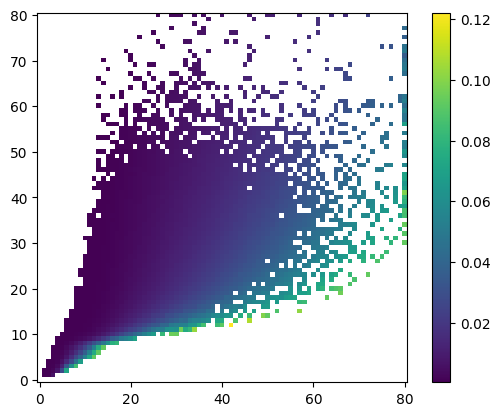

In [37]:
plt.imshow(sigma_density_winter_ocean_models[2].T, origin = 'lower')
plt.colorbar()

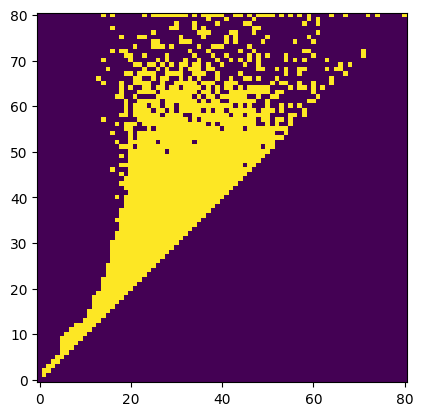

In [42]:
plt.imshow(jds_winter[2].mask_coloc_c.T, origin = 'lower')